## Hadoop Streaming

### Подготовка hadoop streaming 

<h5>
Домашняя директория Hadoop:
</h5>

- $ export HADOOP_HOME=/usr/local/Cellar/hadoop/2.8.0

<h5>
Найдем  jar-файл hadoop streaming:
</h5>

- $ find /usr/local/Cellar/hadoop \-name hadoop-*streaming*.jar -print

<h5> 
jar-файл hadoop streaming:
</h5>

- $HADOOP_HOME/libexec/share/hadoop/tools/lib/hadoop-streaming-2.8.0.jar
- /usr/local/Cellar/hadoop/2.8.0/libexec/share/hadoop/tools/lib/hadoop-streaming-2.8.0.jar

#### Параметры запуска hadoop streaming: 

  - -D .... - любые параметры MapReduce-задачи;
  - -input /in_file - входной файл, содержимое которого необходимо проанализировать (может храниться в hdfs или local);
  - -output /out_file - выходной файл, куда записывается результат (может храниться в hdfs или local);
  - -mapper - команда(python)/класс(java), который принят за маппера;
  - -reducer - команда(python)/класс(java), который будет принят за редьюсер;
  - -file/fiels - фойл/файлы, которые будут загруженны на каждую датаноду (DataNode).
  - и т.д.

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext(appName="Hadoop Streaming")
hdfs = "hdfs://localhost:9000/"

#### Скрипт для запуска простой map reduce задачи, с использованием shell-команд unix

- /user/askar/cite75_99.txt - входной файл из hdfs
- /user/askar/output - выходная директория в hdfs
- cut -f 2 -d  - извлекает ханные из второго столбца файла
- uniq  - удаляет дубликаты из отсортированных данных

#### Пример № 1.  Запуска MapReduce задачи на python. Вывод 10% всей записи.

In [30]:
# random_sample.py

import sys, random
for line in sys.stdin:
    if (random.randint(1, 100) <= int(sys.argv[1])):
        print(line.strip())

#### Команда запуска MapReduce задачи с командной строки с аргументами. 

    - mapreduce.job.reduces=1 - используем 1 редьюсер
    - /user/askar/cite75_99.txt -  из hdfs
    - /user/askar/output - в hdfs
    - "python3 /Users/shabykov/Hadoop/random_sample.py 10" - команда на локальной машине
    - /Users/shabykov/Hadoop/random_sample.py - путь/файл на локальной машине

#### Пример № 2. Скрипт для вычисления максимального значения атрибута.

In [ ]:
# attribute_max.py 
import sys

index = int(sys.argv[1]) if len(sys.argv) > 1 else 8
maximum = 0
for line in sys.stdin:
    fields = line.strip().split(",")
    if fields[index].isdigit():
        val = int(fields[index])
        if val > maximum:
            maximum = val
else:
    print(maximum)

In [40]:
out_file = sc.textFile(hdfs + "/user/askar/output")

In [41]:
out_file.collect()

['706\t', '868\t']

Ны выходе 2 мапперов получили два максимальных числа 706 и 868. Давайте подключим редюсер, чтобы получить максимальное число из чисел полученных на выходе мапперов. 
Редюсер тот же маппер с аргусентом 0. 

hadoop jar $HADOOP_HOME/libexec/share/hadoop/tools/lib/hadoop-streaming-2.8.0.jar \ 
    -D mapreduce.job.reduces=1 \ 
    -input /user/askar/apat63_99.txt \
    -output /user/askar/output \ 
    -mapper "python3 /Users/shabykov/Hadoop/attribute_max.py 8" \
    -reducer "python3 /Users/shabykov/Hadoop/attribute_max.py 0"
    -file /Users/shabykov/Hadoop/attribute_max.py

In [42]:
out_data = sc.textFile(hdfs + "/user/askar/output")

In [43]:
out_data.collect()

['868\t']

#### Пример № 3. Вычисление среднего количества пунктов в формуле изобретения патента для каждой страны. 

Mapper фильтрует данные, выводит ключ - код страны, значение - количество пунктов в формуле. 

In [44]:
# average_by_attribute_mapper.py

import sys

for line in sys.stdin:
    fields = line.split(",")
    if fields[8] and fields[8].isdigit():
        print(fields[4][1:-1] + '\t' + fields[8])


In [52]:
out_data = sc.textFile(hdfs + "/user/askar/output/part-00000")

In [56]:
for val in out_data.collect()[:32]:
    print(val)

AD	7
AD	14
AD	28
AD	12
AD	9
AE	4
AE	12
AE	24
AE	16
AE	11
AE	35
AE	16
AE	20
AE	10
AE	7
AE	23
AE	26
AE	11
AE	12
AE	4
AG	20
AG	7
AG	8
AG	12
AG	3
AG	24
AG	14
AG	18
AI	10
AM	18
AN	3
AN	26


Reducer считает среднее значение данных по опредделенному ключу

In [45]:
# average_by_attribute_reducer.py

import sys

last_key, count, summ = None, 0, 0.0
for line in sys.stdin:
    (key, val) = line.split("\t")
    
    if last_key and last_key != key:
        print("{}\t{}".format(last_key, summ / count))
        summ, count = 0.0, 0
    
    last_key = key
    summ += float(val)
    count += 1

if last_key:
    print("{}\t{}".format(last_key, summ / count))

In [57]:
out_data = sc.textFile(hdfs + "/user/askar/output/part-00000")

In [58]:
for val in out_data.collect()[:15]:
    print(val)

AD	14.0
AE	15.4
AG	13.25
AI	10.0
AM	18.0
AN	9.625
AR	9.188990825688073
AT	10.683988393563704
AU	12.291563832174107
AW	15.5
AZ	11.0
BB	11.0
BE	11.945544554455445
BG	4.989949748743719
BH	6.5


#### Интерфейс Streaming и пакет Aggregate

<table>
    <tr>
        <td><h5>Агрегатор значений (функция)</h5></td>
        <td><h5>Описание</h5></td>
    </tr>
    <tr>
        <td>DoubleValueSum</td>
        <td>Вычисляет сумму значениу по определенному ключу (double)</td>
    </tr>
    <tr>
        <td>LongValueSum</td>
        <td>Вычисляет сумму значениу по определенному ключу (long)</td>
    </tr>
    <tr>
        <td>LongValueMax</td>
        <td>Находит максимум в последовательности значений по определенному ключу (double)</td>
    </tr>
    <tr>
        <td>LongValueMin</td>
        <td>Находит минимум в последовательности значений по определенному ключу (long)</td>
    </tr>
    <tr>
        <td>StringValueMax</td>
        <td>Находит лексинрафический максимум в последовательности значений по определенному ключу (string)</td>
    </tr>
    <tr>
        <td>StringValueMin</td>
        <td>Находит лексинрафический минимум в последовательности значений по определенному ключу (string)</td>
    </tr>
    <tr>
        <td>UniqValueCount</td>
        <td>Подсчитывает количество уникальных элементов в посследовательности значений.</td>
    </tr>
    <tr>
        <td>ValueHistogram</td>
        <td>Находит количество, минимум, максимум, медиану, среднее, стандартное отклонение значений для каждого ключа.</td>
    </tr>
</table>

#### Пример № 4. Вычисление количества патентов в год. 

In [ ]:
# attribute_count_aggregate.py

import sys

index = 1 # колонка с годом 
for line in sys.stdin:
    fields = line.strip().split(",")
    print("LongValueSum:{}\t{}".format(fields[index], 1))

In [65]:
out_data = sc.textFile(hdfs + "/user/askar/output/part-00000")

In [67]:
for val in out_data.collect():
    print(val)

"GYEAR"	1
1963	45679
1964	47375
1965	62857
1966	68405
1967	65652
1968	59104
1969	67559
1970	64429
1971	78317
1972	74810
1973	74143
1974	76278
1975	72000
1976	70226
1977	65269
1978	66102
1979	48854
1980	61819
1981	65771
1982	57888
1983	56860
1984	67200
1985	71661
1986	70860
1987	82952
1988	77924
1989	95537
1990	90364
1991	96513
1992	97444
1993	98342
1994	101676
1995	101419
1996	109645
1997	111983
1998	147519
1999	153486


In [73]:
x = np.array([[v for v in line.split("\t")] for line in out_data.collect()])

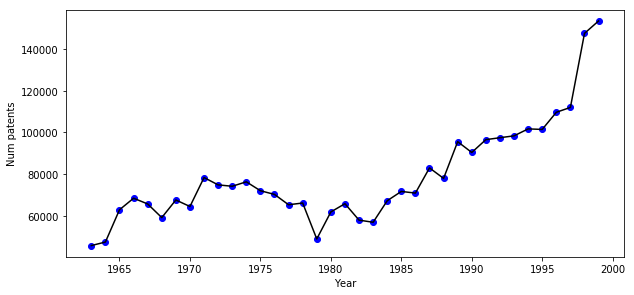

In [85]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(x.T[0][1:], x.T[1][1:], 'bo', x.T[0][1:], x.T[1][1:], 'k')
plt.xlabel('Year')
plt.ylabel('Num patents')
plt.show()

#### Пример № 5. Определить, увеличилось ли количество стран использующих патентную систему. 
Необходимо для каждого года (GYEAR - колонка 1) посчитать количество стран (COUNTRY - колонка 4) подавших на патент.

In [ ]:
# uniq_value_count.py

import sys

year_index = int(sys.argv[1]) # 1
contry_index = int(sys.argv[2]) # 4

for line in sys.stdin:
    fields = line.split(",")
    print("UniqValueCount:{}\t{}".format(fields[year_index], fields[contry_index]))


In [88]:
out_data = sc.textFile(hdfs + "/user/askar/output/part-00000")

In [90]:
for val in out_data.collect():
    print(val)

"GYEAR"	1
1963	64
1964	58
1965	67
1966	71
1967	68
1968	71
1969	68
1970	72
1971	74
1972	76
1973	72
1974	77
1975	73
1976	71
1977	76
1978	70
1979	67
1980	71
1981	71
1982	62
1983	65
1984	70
1985	74
1986	69
1987	74
1988	72
1989	79
1990	70
1991	75
1992	76
1993	83
1994	88
1995	89
1996	90
1997	89
1998	94
1999	108


In [91]:
x = np.array([[v for v in line.split("\t")] for line in out_data.collect()])

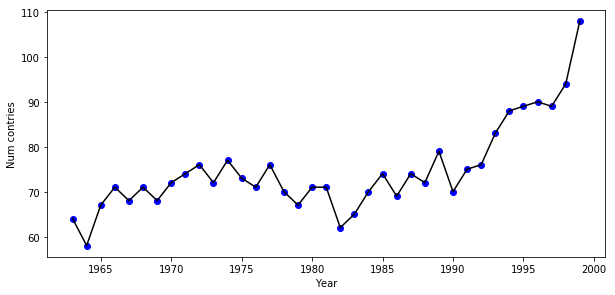

In [92]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(x.T[0][1:], x.T[1][1:], 'bo', x.T[0][1:], x.T[1][1:], 'k')
plt.xlabel('Year')
plt.ylabel('Num contries')
plt.show()

#### Пример № 6. Найти распределение стран, в которых выдавались патенты по годам.


In [ ]:
# value_histogram.py
import sys

year_index = int(sys.argv[1])
contry_index = int(sys.argv[2])

for line in sys.stdin:
    fields = line.split(",")
    print("ValueHistogram:{}\t{}\t{}".format(fields[year_index], fields[contry_index], 1))

In [93]:
out_data = sc.textFile(hdfs + "user/askar/output")

In [94]:
for val in out_data.collect():
    print(val)

"GYEAR"	1	1	1	1	1.0	0.0
1963	64	1	5	37174	713.734375	4610.076525402627
1964	58	1	7	38410	816.8103448275862	4997.413601595352
1965	67	1	5	50331	938.1641791044776	6104.779230296307
1966	71	1	5	54634	963.4507042253521	6443.625995189338
1967	68	1	8	51274	965.4705882352941	6177.445623039149
1968	71	1	7	45781	832.4507042253521	5401.229955880634
1969	68	1	8	50394	993.5147058823529	6080.713518728092
1970	72	1	7	47073	894.8472222222222	5527.883233761672
1971	74	1	9	55976	1058.337837837838	6492.837390992137
1972	76	1	7	51518	984.3421052631579	5916.340924557642
1973	72	1	10	51501	1029.763888888889	6066.751172701396
1974	77	1	8	50646	990.6233766233767	5794.207539776167
1975	73	1	9	46715	986.3013698630137	5501.2231458973765
1976	71	1	11	44280	989.0985915492957	5299.050345839762
1977	76	1	8	41490	858.8026315789474	4801.305653070173
1978	70	1	11	41254	944.3142857142857	4984.348799830059
1979	67	1	10	30078	729.1641791044776	3718.7885990853274
1980	71	1	11	37354	870.6901408450705	4504.845371317451
1981

Год , Количество стран уникальных стран (UniqValueCount), Минимальное количество стран (LongValueMin), Медиана, Максимум, Среднее, Дисперсия 

In [98]:
x = np.array([[v for v in line.split("\t")] for line in out_data.collect()])

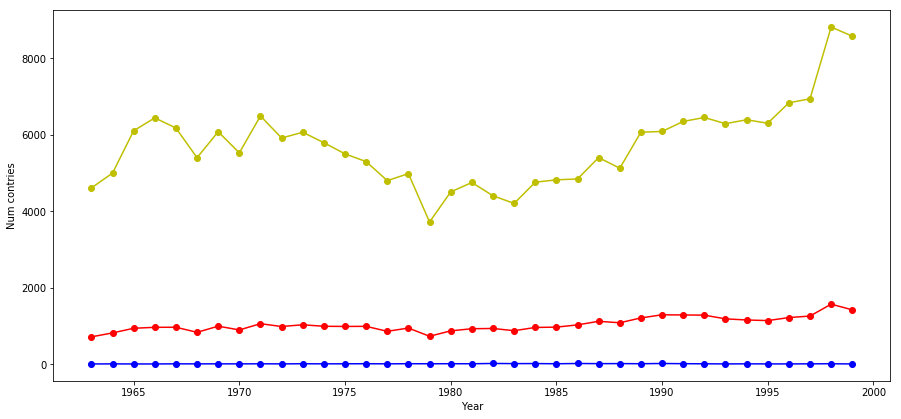

In [111]:
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.plot(x.T[0][1:], x.T[3][1:], 'bo', x.T[0][1:], x.T[3][1:], 'k', color='b', label='median')
plt.plot(x.T[0][1:], x.T[5][1:], 'bo', x.T[0][1:], x.T[5][1:], 'k', color='r', label='mean')
plt.plot(x.T[0][1:], x.T[6][1:], 'bo', x.T[0][1:], x.T[6][1:], 'k', color='y', label='disper')
plt.xlabel('Year')
plt.ylabel('Num contries')
plt.show()

In [112]:
sc.stop()